# 2.4 Scaling with Pangeo

<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

<img src="https://raw.githubusercontent.com/pangeo-data/pangeo.io/refs/heads/main/public/Pangeo-assets/pangeo_logo.png"
     alt="Pangeo logo"
     style="float: center; margin-right: 10px;" />

## Parallel computing with Dask

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> <b>Overview</b>
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Dask?</li>
        <li>How can I parallelize my data analysis with Dask?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Dask</li>
        <li>Learn about Dask Gateway, Dask Client, Scheduler, Workers</li>
        <li>Understand out-of-core and speed-up limitations</li>
    </ul>
</div>

## Context

We will be using [Dask](https://docs.dask.org/) with [Xarray](https://docs.xarray.dev/en/stable/) to parallelize our data analysis.  We will continue to use the NDVI example.  


## Parallelize with Dask

We know from the previous exercise **2.4_chunking** that chunking is key to analyzing large data sets. In this exercise, we will learn how to parallelize our data analysis using [Dask](https://docs.dask.org/) on our chunked dataset. 

### What is [Dask](https://docs.dask.org/) ?

**Dask** is a powerful and flexible library for parallel computing in Python. It enables users to scale their computations effortlessly while working with large datasets that exceed available memory.

- With minimal code changes, Dask accelerates existing Python libraries such as NumPy, Pandas, and Scikit-learn.
- Designed for processing massive datasets, Dask is widely used in Earth Science and other data-intensive fields.
- It scales effortlessly from a single laptop to clusters, cloud environments, and HPC systems.
- Dask bridges the gap between exploratory analysis and large-scale production workflows.


#### How does Dask scale and accelerate your data analysis?

[Dask proposes different abstractions to distribute your computation](https://docs.dask.org/en/stable/10-minutes-to-dask.html). In this _Dask Introduction_ section, we will focus on [Dask Array](https://docs.dask.org/en/stable/array.html) which is widely used in the Pangeo ecosystem as a backend of Xarray.

The chunks of a Dask Array are standard NumPy arrays. By transforming large datasets into Dask Arrays and utilizing chunks, a large array is handled as many smaller NumPy arrays. This allows us to compute each of these chunks independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)  
*Image source: Dask documentation (© 2025 Dask core developers, BSD-3 Licensed).*

<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Note</b>
    <br>
    <ul>
        <li>Xarray uses Dask Arrays instead of Numpy when chunking is enabled, and thus all Xarray operations are performed through Dask, which enables distributed processing. </li>
    </ul>
</div>

#### How does Xarray with Dask distribute data analysis?

When we use chunks with Xarray, the real computation is only done when needed or explicitly requested, usually by invoking the `compute()` or `load()` functions. Dask generates a **task graph** describing the computations to be performed. When using [Dask Distributed](https://distributed.dask.org/en/stable/), a **Scheduler** distributes these tasks across several **Workers**.

![Xarray with dask](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/dask-xarray-explained.png)

#### What is a Dask Distributed cluster?

A Dask Distributed cluster is made up of two main components:

- A __Scheduler__, responsible for handling the computation graph and distributing tasks to Workers.
- One or several __Workers__, which compute individual tasks and store results and data in distributed memory (RAM and/or the worker's local disk).

A user typically needs __Client__ and __Cluster__ objects, as shown below, to use Dask Distributed.


![Dask Distributed Cluster](https://user-images.githubusercontent.com/306380/66413985-27111600-e9be-11e9-9995-8f418ff48f8a.png)

#### Where can we deploy a Dask distributed cluster?

[Dask distributed clusters can be deployed on your laptop or on distributed infrastructures (Cloud, HPC centers, Hadoop, etc.).](https://docs.dask.org/en/stable/deploying.html)  Dask distributed `Cluster` object is responsible of deploying and scaling a Dask Cluster on the underlying resources.

![Dask Cluster deployment](https://docs.dask.org/en/stable/_images/dask-cluster-manager.svg)*Image source: Dask documentation (© 2025 Dask core developers, BSD-3 Licensed).*

> Tip  
> A Dask `Cluster` can be created on a single machine (e.g. your laptop), which means you do not need dedicated computing resources. This corresponds to **Vertical scaling** as described in lecture [2.4 Formats and Performance](../2.4_formats_and_performance.md).
>
> However, the speed up is limited to the resources of your single machine. This is where **horizontal scaling** comes in.  By adding resources from other machines, you can expand your computing power!

### Dask distributed Client
 
The Dask distributed `Client` is what allows you to interact with Dask distributed Clusters. When using Dask distributed, you always need to create a `Client` object. Once a `Client` has been created, it will be used by default by each call to a Dask API, even if you do not explicitly use it.

No matter the Dask API (e.g. Arrays, Dataframes, Delayed, Futures, etc.) that you use, under the hood, Dask will create a Directed Acyclic Graph (DAG) of tasks by analysing the code. Client will be responsible to submit this DAG to the Scheduler along with the final result you want to compute. The Client will also gather results from the Workers, and aggregate it back in its underlying Python process.

Using `Client()` function with no argument, you will create a local Dask cluster with a number of workers and threads per worker corresponding to the number of cores in the 'local' machine. The 'local' machine is the jupyterlab you are using in the Cloud, and the number of cores is the number of cores available in the cloud instance (not on your laptop).

In [1]:
from dask_gateway import JupyterHubAuth, Gateway
gateway = Gateway()
cluster_options = gateway.cluster_options()
cluster = gateway.new_cluster(cluster_options=cluster_options)
cluster.scale(3)  # create a local dask cluster on the local machine specifying 3
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.earthcode.eox.at/services/eoxhub-gateway/cubes-and-clouds/traefik-dask-gateway/clusters/cubes-and-clouds.2c86221c2f1a4c72acb054d2ad2da70f/status,


Inspecting the `Cluster Info` section above gives us information about the created cluster: we have 2 or 4 workers and the same number of threads (e.g. 1 thread per worker).

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go further</b>
    <br>
    <ul>
        <li> You can also create a local cluster with the `LocalCluster` constructor and use `n_workers` 
        and `threads_per_worker` to manually specify the number of processes and threads you want to use. 
        For instance, we could use `n_workers=2` and `threads_per_worker=2`.  </li>
        <li> This is sometimes preferable (in terms of performance), or when you run this tutorial on your PC, 
        you can avoid dask to use all your resources you have on your PC!  </li>
    </ul>
</div>

### Dask Dashboard

Dask comes with a really handy interface: the Dask Dashboard. It is a web interface that you can open in a separate tab of your browser.

We will learn how to use it through the [dask jupyterlab extension](https://github.com/dask/dask-labextension).  

To use Dask Dashboard through jupyterlab extension,
you just need to click on the orange icon shown in the following figure,

![Dask.array](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/dashboardlink.png)

You can click several buttons marked with blue arrows in the following images, and then drag and drop them wherever you want.  

![Dask.array](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/dasklab.png)




![Dask.array](https://raw.githubusercontent.com/EO-College/cubes-and-clouds/refs/heads/main/lectures/2.4_formats_and_performance/exercises/assets/exampledasklab.png)

It's really helpful to understand your computation and how it's distributed.

## Dask Distributed computations on our dataset

Let's open the Zarr dataset we've prepared in [previous chunking excersise](./24_chunking.ipynb), select a single location over time, visualize the task graph generated by Dask, and observe the Dask Dashboard.



In [2]:
import xarray as xr
ndvi = xr.open_zarr('test.zarr')
ndvi

<xarray.Dataset> Size: 211MB
Dimensions:                                  (time: 3, y: 3341, x: 2630)
Coordinates: (12/33)
    constellation                            <U10 40B ...
    created                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:boa_offset_applied           (time) bool 3B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:payload_id                   (time) <U74 888B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:s3_path                      (time) <U79 948B dask.array<chunksize=(3,), meta=np.ndarray>
    eo:cloud_cover                           (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                                       ...
  * time                                     (time) datetime64[ns] 24B 2019-0...
    updated                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_azimuth                         (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_elevation                       (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...
Data variables:
    data                                     (time, y, x) float64 211MB dask.array<chunksize=(1, 3341, 2630), meta=np.ndarray>
    spatial_ref                              int64 8B ...

In [3]:
ndvi['data'].mean(dim='x')

<xarray.DataArray 'data' (time: 3, y: 3341)> Size: 80kB
dask.array<mean_agg-aggregate, shape=(3, 3341), dtype=float64, chunksize=(1, 3341), chunktype=numpy.ndarray>
Coordinates: (12/32)
    constellation                            <U10 40B ...
    created                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:boa_offset_applied           (time) bool 3B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:payload_id                   (time) <U74 888B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:s3_path                      (time) <U79 948B dask.array<chunksize=(3,), meta=np.ndarray>
    eo:cloud_cover                           (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                                       ...
    s2:sequence                              (time) <U1 12B dask.array<chunksize=(3,), meta=np.ndarray>
  * time                                     (time) datetime64[ns] 24B 2019-0...
    updated                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_azimuth                         (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_elevation                       (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
  * y                                        (y) float64 27kB 5.202e+06 ... 5...

## Did you notice something on the Dask Dashboard when running the two previous cells?

We didn't actually 'compute' anything. Instead, we built a Dask task graph, with its size indicated as a count above, but we didn't ask Dask to return a result.

You can check the 'Dask graph' to see how many layers it contains, which will help you estimate the complexity of your computation.

It shows that you have '4 graphs'. This can be optimized in the following steps.

Let's try to plot the Dask graph before computation and understand what the Dask workers will do to compute the result we asked for.


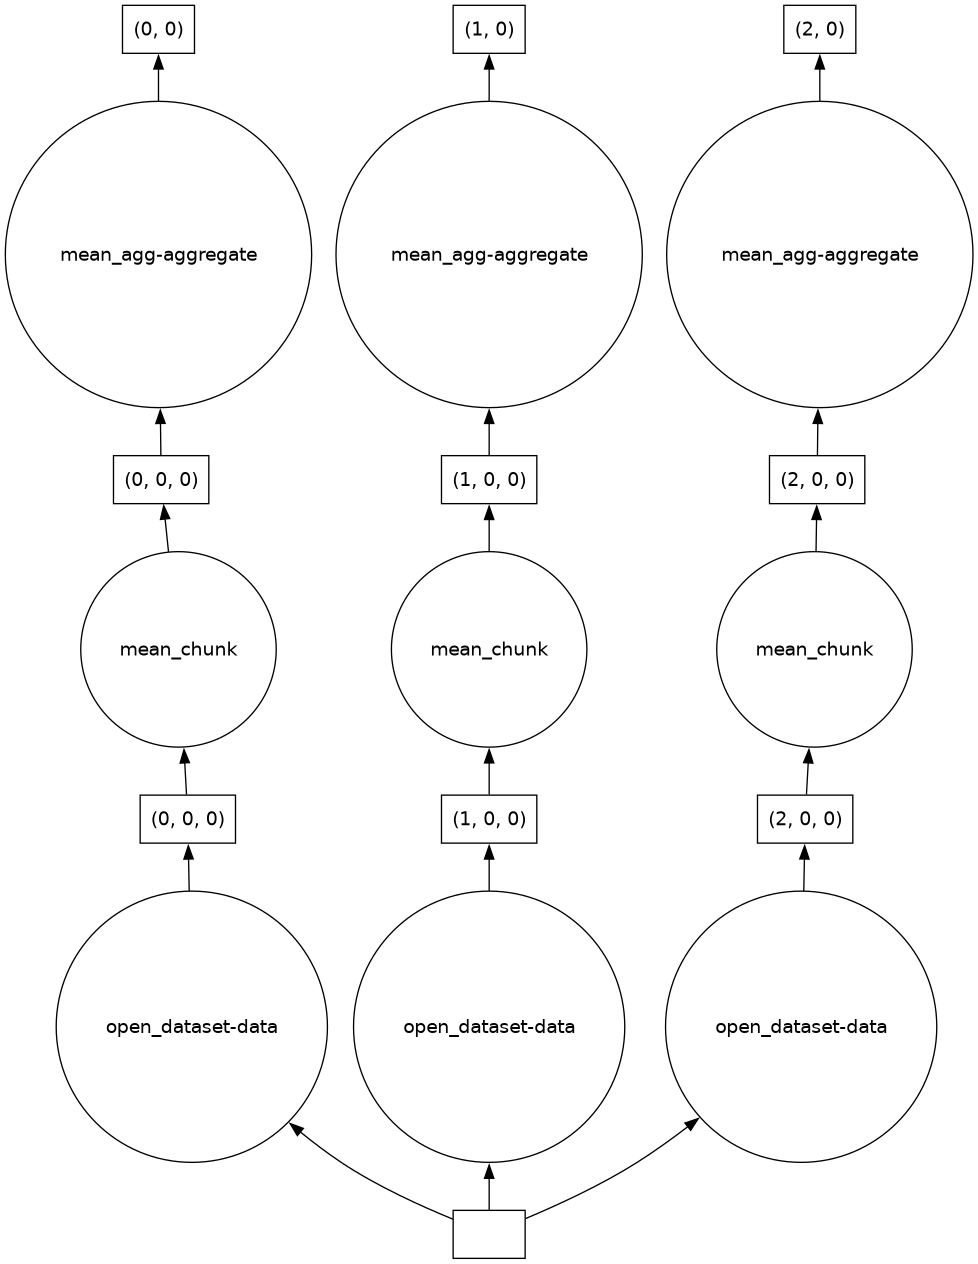

In [4]:
ndvi['data'].mean(dim='x').data.visualize()

Let's average the time dimension and see how it differs

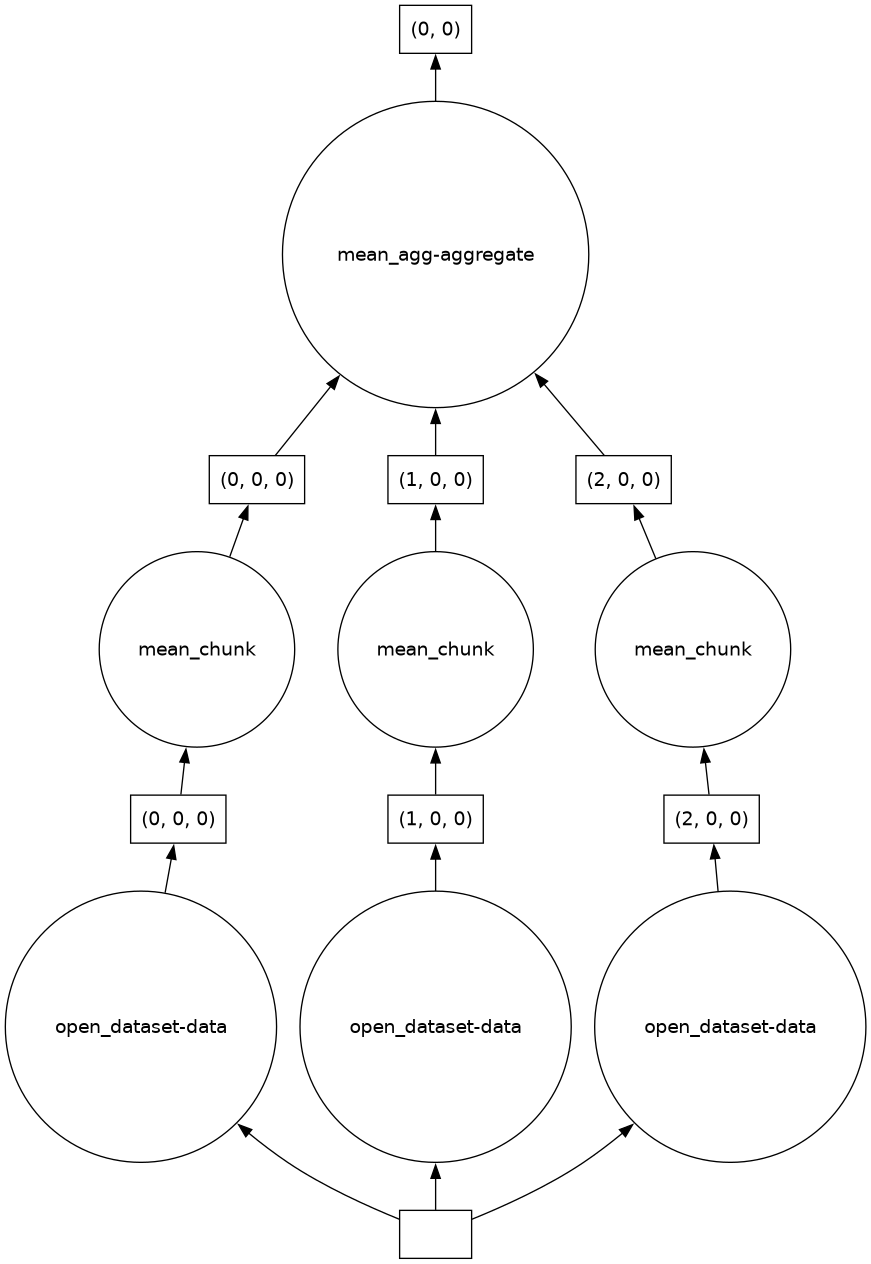

In [5]:
ndvi['data'].mean(dim='time').data.visualize()

### Let's compute on the Dask workers

In [6]:
ndvi['data'].mean(dim='time').compute()

<xarray.DataArray 'data' (y: 3341, x: 2630)> Size: 70MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(3341, 2630))
Coordinates:
    constellation                            <U10 40B 'sentinel-2'
    epsg                                     int64 8B 32632
    gsd                                      int64 8B 10
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'T'
    mgrs:utm_zone                            int64 8B 32
    proj:epsg                                int64 8B 32632
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:saturated_defective_pixel_percentage  int64 8B 0
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...

Calling compute on our Xarray object triggered the execution on Dask Cluster side. 

You should be able to see how Dask is working on Dask Dashboard. 

### Let's try a bigger computation
We will re-use the procedure we've learned in the previous chunking notebook.


In [7]:
### Load data using stackstac (with specific chunk) 
import stackstac
import pystac_client
import geopandas as gpd
from shapely.geometry import mapping
import numpy as np
import warnings
import rioxarray

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", RuntimeWarning)

aoi = gpd.read_file('./assets/catchment_outline.geojson', crs="EPGS:4326")
aoi_geojson = mapping(aoi.iloc[0].geometry)
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
items = catalog.search(
    intersects=aoi_geojson,
    collections=["sentinel-2-l2a"],
    datetime="2019-02-01/2019-03-28",
    query= {"proj:epsg": dict(eq=32632)}
).item_collection()

ds = stackstac.stack(items,
                     assets=['red','nir'],
                     chunksize=(1,2,1024,1024),
                     epsg = 32632
                    )
ds

<xarray.DataArray 'stackstac-aa62f8e6578d5768117ad9dea72fd911' (time: 56,
                                                                band: 2,
                                                                y: 83380,
                                                                x: 15048)> Size: 1TB
dask.array<fetch_raster_window, shape=(56, 2, 83380, 15048), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 448B 2019-...
    id                                       (time) <U24 5kB 'S2B_32TPT_20190...
  * band                                     (band) <U3 24B 'red' 'nir'
  * x                                        (x) float64 120kB 5.982e+05 ... ...
  * y                                        (y) float64 667kB 5.303e+06 ... ...
    s2:high_proba_clouds_percentage          (time) object 448B 28.474605 ......
    ...                                       ...
    proj:centroid                            (time) object 448B None ... None
    s2:tile_id                               (time) object 448B None ... None
    view:azimuth                             (time) object 448B None ... None
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    epsg                                     int64 8B 32632
Attributes:
    spec:           RasterSpec(epsg=32632, bounds=(598150.5065312386, 5087469...
    crs:            epsg:32632
    transform:      | 7.68, 0.00, 598150.51|\n| 0.00,-2.58, 5302980.29|\n| 0....
    resolution_xy:  (7.681990477386707, 2.584686340731679)

By inspecting any of the variables in the representation above, you'll see that the data array represents **over 188 GiB of data**, which is much more than the available memory on this notebook server or the Dask Local Cluster we created earlier. But thanks to chunking, we can still analyze it!


In [8]:
## Computing the NDVI
def NDVI(data):
    red = data.sel(band="red")
    nir = data.sel(band="nir")
    ndvi = (nir - red)/(nir + red)
    return ndvi

ndvi_xr = NDVI(ds)

## Clip the data
aoi_utm32 = aoi.to_crs(epsg=32632)
geom_utm32 = aoi_utm32.iloc[0]['geometry']
ndvi_xr.rio.write_crs("EPSG:32632", inplace=True)
ndvi_xr.rio.set_nodata(np.nan, inplace=True)
ndvi_xr = ndvi_xr.rio.clip([geom_utm32])
ndvi_xr.rio.set_nodata(np.nan, inplace=True)

ndvi_xr = ndvi_xr.groupby(ndvi_xr.time.dt.floor('D')).max(skipna=True)
ndvi_xr = ndvi_xr.chunk({"floor": 1, "y": 2048, "x": 2048})
ndvi_xr

<xarray.DataArray 'stackstac-aa62f8e6578d5768117ad9dea72fd911' (floor: 23,
                                                                y: 12926,
                                                                x: 3423)> Size: 8GB
dask.array<rechunk-merge, shape=(23, 12926, 3423), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * x                                        (x) float64 27kB 6.543e+05 ... 6...
  * y                                        (y) float64 103kB 5.202e+06 ... ...
    proj:code                                <U10 40B 'EPSG:32632'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    constellation                            <U10 40B 'sentinel-2'
    instruments                              <U3 12B 'msi'
    ...                                       ...
    mgrs:utm_zone                            int64 8B 32
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0
  * floor                                    (floor) datetime64[ns] 184B 2019...
Attributes:
    _FillValue:  nan

Perform the same steps as in the previous exercise to convert to a Dataset and clean out problematic attributes

In [9]:
ndvi_xr = ndvi_xr.to_dataset(name='data')

def remove_attrs(obj, to_remove):
    new = obj.copy()
    new.attrs = {k: v for k, v in obj.attrs.items() if k not in to_remove}
    return new

def encode(obj):
    object_coords = [name for name, coord in obj.coords.items() if coord.dtype.kind == "O"]
    return obj.drop_vars(object_coords).pipe(remove_attrs, ["spec", "transform"])

ndvi_xr = ndvi_xr.pipe(encode)

In [11]:
from dask.diagnostics import ProgressBar
ndvi_w = ndvi_xr.persist()
with ProgressBar():
    ndvi_w.to_zarr("ndvi.zarr", mode="w", consolidated=True)

FutureCancelledError: finalize-hlgfinalizecompute-7bcd06d0559948638d7f848a63af28f9 cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [ ]:
%%time
import numpy
with np.errstate(all="ignore"):
    ndvi_xr.to_zarr('ndvi.zarr',mode='w')

### Close client to terminate local dask cluster

The `Client` and associated `LocalCluster` object will be automatically closed when your Python session ends. When using Jupyter notebooks, we recommend to close it explicitely whenever you are done with your local Dask cluster.

In [ ]:
client.close()

## Conclusion

In this exercise, we created a Dask cluster on a single machine, which is equivalent to vertical scaling as described in **2.4 Formats and Performance**. 

However, the speedup is limited to the resources of your single machine. This is where horizontal scaling comes in. By adding resources from other machines, you can expand your computing power! In the case of dask, you can use the [Dask Gatway](https://gateway.dask.org/#dask-gateway).   
The Pangeo community hosts tutorials using [Pangeo@EOSC]('https://pangeo-eosc.vm.fedcloud.eu/hub/'). With the Pangeo EOSC deployment, you can learn how to use Dask Gateway to manage Dask clusters over Kubernetes, allowing us to run our data analysis in parallel, e.g. distribute tasks across multiple workers.
If you are a user of HPC center, you can also consider using [Dask-jobque](https://docs.dask.org/en/stable/deploying-hpc.html#high-performance-computers) or Dask HPC for this.  